To demonstrate the use of MaxWEnt with TensorFlow, we consider a two-dimensional classification problem where the input space, $\mathcal{X}$ lie in $\mathbb{R}^2$, and the output (label) space, $\mathcal{Y}$, is composed of two classes, such that $\mathcal{Y} = \{0, 1\}$.

The training instances are drawn according to the [*two-moons*](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) classification problem from scikit-learn. Please install `scikit-learn` to run this tutorial.

## Setup

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from maxwent import classification_2d, plot_classification_2d

Below is an illustration of the problem. The training data are concentrated in the center of the input space, leaving a significant portion of $\mathcal{X}$ outside the distribution. In other words, a large regio of the input space remains uncovered by the training data.

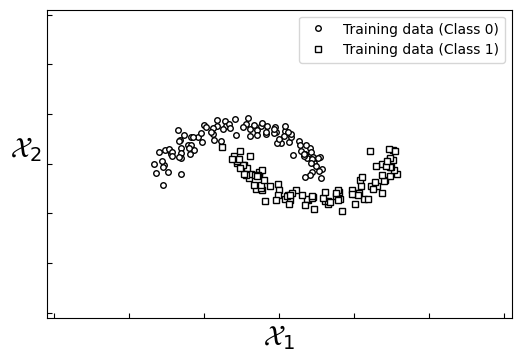

In [18]:
x_train, y_train, x_ood = classification_2d()
ax = plot_classification_2d(x_train, y_train, x_ood)
ax.legend(loc="upper right"); plt.show()

## Base Network

Next, we define the neural network architecture. We use a fully connected network consisting of two dense layers with ReLU activation functions. Since this is a binary classification task, the output layer has a sigmoid activation function.

In [19]:
import tensorflow as tf

base_net = tf.keras.Sequential()
base_net.add(tf.keras.layers.Input(shape=(2,)))
base_net.add(tf.keras.layers.Dense(100))
base_net.add(tf.keras.layers.ReLU())
base_net.add(tf.keras.layers.Dense(100))
base_net.add(tf.keras.layers.ReLU())
base_net.add(tf.keras.layers.Dense(1, activation="sigmoid"))
base_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,501 (41.02 KB)

 Trainable params: 10,501 (41.02 KB)

 Non-trainable params: 0 (0.00 B)

We specify the loss function and optimizer for training. In this case, we use the binary cross-entropy (BCE) loss, which is a standard choice for classification problems.

In [20]:
base_net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="bce")
base_net.fit(x_train, y_train, epochs=250, verbose=0);

Now that the network has been trained on the training data, we visualize its predictions across the entire input space $\mathcal{X}$. The predicted values are shown in purple in the figure below.

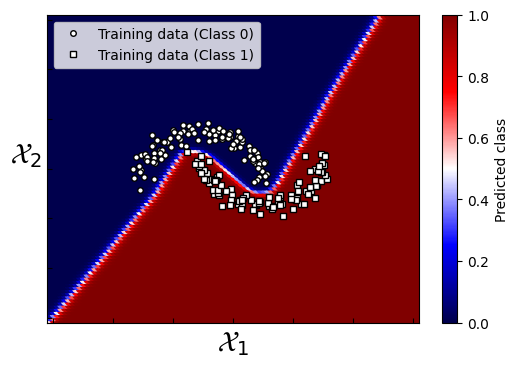

In [11]:
y_pred = base_net.predict(x_ood, verbose=0)

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=y_pred, cmap="seismic")
plt.colorbar(unc, ax=ax, label='Predicted class')
ax.legend(loc="upper left"); plt.show()

As we can see, the model divides the input domain into two distinct regions, each assigned to one of the classes.

However, this decision relies on a strong extrapolation—assuming that each class naturally extends into its respective region, with class 0 occupying the upper part and class 1 the lower. In reality, alternative explanations exist. The true decision boundary could follow a more complex pattern, such as a twisted spiral, challenging the model’s assumptions. Another possibility is that out-of-distribution data do not belong to either class 0 or 1 but instead represent entirely new, unseen classes.

To quantify the uncertainty of out-of-distribution data classification, it is essential to have a reliable uncertainty estimator. A common approach is to use the classifier’s output, which ranges between 0 and 1, as a proxy for probability. From this, one can compute the entropy of the predictions at any given point in the input space, providing a measure of uncertainty. Below, we visualize this uncertainty using shades of blue.

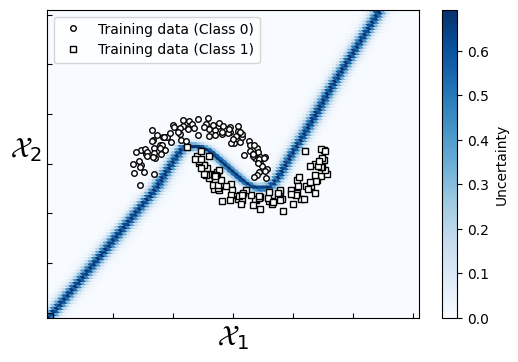

In [13]:
y_pred = base_net.predict(x_ood, verbose=0).ravel()

uncertainties = -y_pred * np.log(y_pred + 1e-8) - (1 - y_pred) * np.log(1 - y_pred + 1e-8)

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=uncertainties, cmap="Blues")
plt.colorbar(unc, ax=ax, label='Uncertainty')
ax.legend(loc="upper left"); plt.show()

As observed, the estimated uncertainty is larger primarily in the region between the two classes, while the network assigns no uncertainty elsewhere. However, it is important to clarify that the uncertainty estimated from the network’s output is not specifically designed to capture epistemic uncertainty—i.e., the uncertainty arising from a lack of knowledge about the true underlying classification function. The most principle way to estimate epistemic uncertainty is through the use of an ensemble of classifiers. Due to differences in initialization and the stochastic nature of gradient descent, an ensemble of networks will emerge. The diversity in their predictions serves as an indicator of epistemic uncertainty, helping us assess the confidence of our model in regions with little to no training data.

## Deep Ensemble

The following code builds an ensemble of five networks, each trained independently on the same training data.

In [15]:
deep_ens = []

for _ in range(5):
    net = tf.keras.models.clone_model(base_net)
    net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="bce")
    net.fit(x_train, y_train, epochs=250, verbose=0);
    deep_ens.append(net)

y_preds = [
    net.predict(x_ood, batch_size=1000, verbose=0)
    for net in deep_ens
]

The standard deviation of the predictions provide an estimatiom of the epistemic uncertainty.

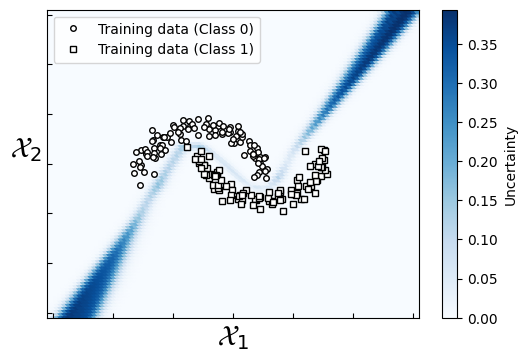

In [16]:
uncertainties = np.std(y_preds, axis=0)

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=uncertainties, cmap="Blues")
plt.colorbar(unc, ax=ax, label='Uncertainty')
ax.legend(loc="upper left"); plt.show()

As we can see, the diversity of predictions remains quite limited, with a significant portion of the out-of-distribution data receiving low uncertainty estimates.

The core issue is that the ensemble lacks sufficient diversity. Despite variations in initialization and training, the networks tend to converge to similar solutions, limiting their ability to express different perspectives on uncertain regions.

This is precisely where MaxWent comes into play. Its objective is to maximize diversity within the ensemble, ensuring a broader exploration of possible predictions.

## Maximum Weight Entropy

To achieve this, we first introduce stochasticity into the network by using the `set_maxwent_model` function. This function replaces every `Dense` layer in the previous network with a `DenseMaxWEnt` layer.

In [21]:
from maxwent import set_maxwent_model

stoch_net = set_maxwent_model(base_net)
stoch_net.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3_mwe (DenseMaxWEnt)      │ (None, 100)            │           604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2_mwe (ReLU)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4_mwe (DenseMaxWEnt)      │ (None, 100)            │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3_mwe (ReLU)              │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5_mwe (DenseMaxWEnt)      │ (None, 1)              │        10,202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,006 (160.18 KB)

 Trainable params: 10,501 (41.02 KB)

 Non-trainable params: 30,505 (119.16 KB)

### Stochasticity

The DenseMaxWEnt layer behaves similarly to a regular Dense layer, with one key difference: during each forward pass, the weights are sampled randomly from a distribution. Specifically, each weight $W_{ij}$ of the weight matrix $W$ is drawn according to the following distribution: 

$$ W_{ij} \sim \overline{W_{ij}} + \phi_{ij} \, z_{ij} $$

where  $z_{ij}$  follows a standard distribution, either uniform or normal with a mean of 0. Here, $\overline{W}$ represents the weight matrix of the base network (`base_net`), which has been pretrained on the training data and remains frozen (i.e., non-trainable). The only trainable parameters are the $\phi_{ij}$, which are the variances of the weight distributions. Note that the matrix $\phi$ has the same shape as $\overline{W}$, equal to `(input_dim, output_dim)`, with `input_dim` the number of neurons of the previous layer and `output_dim` the number of neurons of the current layer.

As we can see from the model summary, we now have ~40,000 parameters instead of ~10,000. However, only ~10,000 of these are trainable parameters: those being the variance parameters $\phi$. Among the non-trainable parameters are $\overline{W}$ (the frozen base network weights) and a matrix $V$, whose utility will be discussed later.

This stochastic network enables us to sample $z$ to generate different neural networks. The diversity of the resulting ensemble of networks is controlled by the variance parameters $\phi$. If $\phi = 0$, we simply sample the same network as `base_net`.

Conceptually, we can think of this process as sampling within a “ball” centered around the weights of our pretrained base network. To encourage diversity, we aim to maximize the variance parameters $\phi_{ij}$, but we must be cautious not to generate networks that fail to fit the data. In the extreme case where $\phi_{ij} \gg 1$ for any $i, j$, we risk sampling degenerate networks that do not perform well on the training data.

### Objective Function

The `MaxWEnt` trainer below addresses this balance by optimizing the $\phi$ parameters with the following objective function:

$$ \mathbb{E}_z \left[ \sum_{(x, y) \in \mathcal{S}} \ell \left(y, h \left(x, \overline{W} + \phi \odot z \right) \right) \right] + \lambda \sum_{i, j} \log(\phi_{ij}^2) $$

Where:
- $\mathcal{S}$ is the training dataset.
- $\ell(. , .)$ is a loss function (the mean squared error in our case).
- $h(x , W )$ is the prediction of the neural network of weights $W$ for the input data $x \in \mathcal{X}$.
- $\odot$ is the element-wise product between two matrices.
- $z$ follows a standard multivariate distribution with independent components (uniform over [-1, 1] in this case)

The first term of the objective represents the average loss over the training data, which serves to constrain the variances $\phi_{ij}$ from growing too large in directions where perturbations to the weights would deteriorate the training performance. The second term is the entropy of the weight distribution, which encourages the $\phi_{ij}$ to grow as large as possible in directions where perturbations have minimal impact on the training loss. This dual objective ensures both diversity and fit to the training data.

### Training

In [22]:
from maxwent import MaxWEnt

mwe = MaxWEnt(stoch_net, lambda_=1.)

The parameter `lambda_` controls the trade-off between the two objectives. Increasing `lambda_` encourages greater weight diversity, but it should not be set too high, as this may excessively deteriorate the model’s accuracy on the training data. The number of training epochs also plays a role in this process. Typically, a larger `lambda_` can achieve higher weight diversity with fewer epochs, but beyond a certain point, the training loss may increase drastically. A practical heuristic is to increase both `lambda_` and the number of epochs as much as possible without causing the training loss to become unstable. Smaller values of `lambda_` result in a more gradual increase in weight entropy, which allows for greater flexibility in the final stages of training. However, this can also lead to a longer training time before a significant increase in weight entropy occurs.

In [23]:
mwe.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="bce")
mwe.fit(x_train, y_train, epochs=2500, verbose=0);

### Inference

We now make predictions using the MaxWEnt model. It’s important to note that each time `predict` is called, a new set of weights is sampled, resulting in different predictions with every call. To obtain consistent predictions across multiple calls, you can use the `seed` argument. Using a fixed seed is a good practice, as it ensures that the same network is used for each batch during prediction. Without it, a new network is sampled for each batch, which can lead to discontinuous predictions along the input space $\mathcal{X}$.

In [24]:
n_sample = 50

y_preds = [
    mwe.predict(x_ood, batch_size=1000, seed=123+i)
    for i in range(n_sample)
]

Below are the results obtained. As observed, MaxWEnt enhances the diversity of the ensemble of neural networks, although the variability in predictions between networks remains low in some region of the input space.

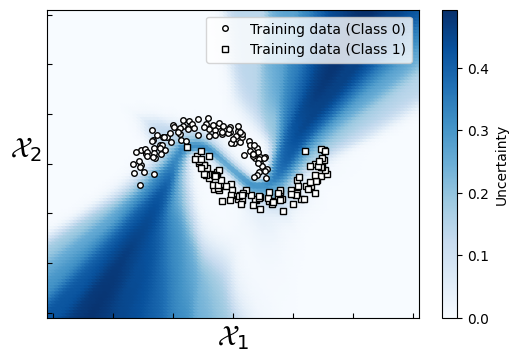

In [25]:
uncertainties = np.std(y_preds, axis=0)

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=uncertainties, cmap="Blues")
plt.colorbar(unc, ax=ax, label='Uncertainty')
ax.legend(loc="upper right"); plt.show()

### Uncertainty Quantification

MaxWEnt provides two built-in methods, `predict_mean` and `predict_std`, which directly compute the mean and standard deviation of predictions across multiple sampled networks. These methods are particularly useful for constructing confidence intervals in regression tasks.

It’s important to note that the `clip` and `n_sample` parameters serve different purposes in these two methods. For `predict_mean`, it is recommended to use a small clip value (or even 0) since excessive diversity can degrade accuracy. By default, `clip` is set to 0, making the model deterministic, and `n_sample` is set to 1, as there is no need to sample multiple networks when there is no weight variance.

On the other hand, when computing the standard deviation using `predict_std`, the goal is to maximize diversity. Therefore, `clip` is set to `None`, meaning no clipping is applied. The `n_sample` parameter is set to 50, ensuring predictions are drawn from 50 different network samples. While increasing `n_sample` generally improves the reliability of uncertainty estimates, it also increases computational cost.

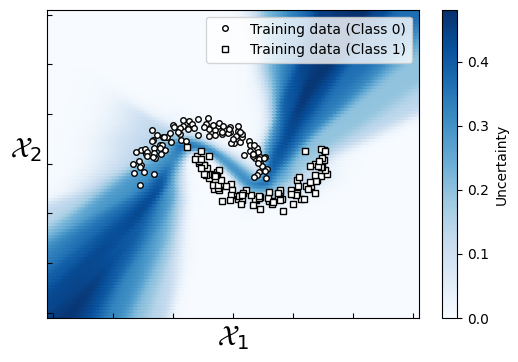

In [18]:
uncertainties = mwe.predict_std(x_ood, batch_size=1000, clip=None, n_sample=50).ravel()

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=uncertainties, cmap="Blues")
plt.colorbar(unc, ax=ax, label='Uncertainty')
ax.legend(loc="upper right"); plt.show()

### SVD Parameterization

In this section of the tutorial, we introduce the SVD parameterization and examine its impact on model predictions. Specifically, we leverage the  $V$  matrix introduced earlier. Each `DenseMaxWEnt` layer includes a non-trainable  $V$  matrix, which serves to introduce correlations between weight components. When applied, the weight distribution follows:


$$ W \sim \overline{W} + V ( \phi \odot z ) $$


If  $V$  is the identity matrix, the formulation remains unchanged from the previous approach, meaning no correlation is introduced between weight components. A key advantage of the  $V$  matrix is that it does not require training alongside  $\phi$ . Instead, it can be precomputed using the `fit_svd` method before training. This is achieved by performing a forward pass of the training data through the base network, after which  $V$  is stored as a fixed, non-trainable parameter.

In [24]:
stoch_net = set_maxwent_model(base_net)
mwe = MaxWEnt(stoch_net, lambda_=1.)

mwe.fit_svd(x_train)

As you can see, the setup remains the same as before, with the only difference being the intermediate step of calling `fit_svd`.

In [25]:
mwe.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse")
mwe.fit(x_train, y_train, epochs=2500, verbose=0);

When analyzing the results, we observe that the epistemic uncertainty estimation is significantly improved with the SVD parameterization.

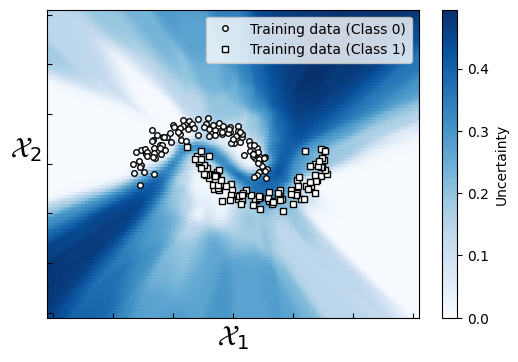

In [21]:
uncertainties = mwe.predict_std(x_ood, batch_size=1000, clip=None, n_sample=50).ravel()

ax = plot_classification_2d(x_train, y_train, x_ood)
unc = ax.scatter(x_ood[:, 0], x_ood[:, 1], c=uncertainties, cmap="Blues")
plt.colorbar(unc, ax=ax, label='Uncertainty')
ax.legend(loc="upper right"); plt.show()

It is worth noting that for this simple 2D case, a distance-based method such as Gaussian processes—where uncertainty is derived from the distance to the training data—could have yielded similar or even better results. However, the real challenge here was to estimate uncertainty through a distribution over the neural network’s weights. The ensemble approach is particularly useful for high-dimensional problems, where defining a meaningful distance metric is not straightforward.